In [2]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

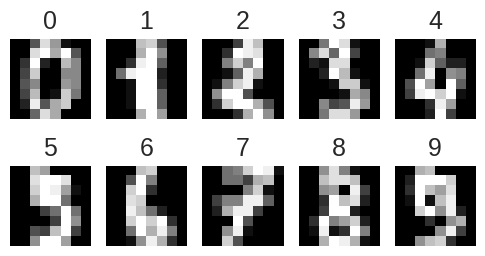

In [70]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('images/digits-generated.png', dpi=150)

In [6]:
# We first reorder the data points according to the handwritten numbers.
print digits.data.shape, digits.target.shape
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
digits_proj = TSNE(random_state=RS).fit_transform(X)
print X.shape
print len(y)

(1797, 64) (1797,)
(1797, 64)
1797


In [65]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, objective_error=None, n_iter_without_progress=40,
                      momentum=0.9, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-9, verbose=0,n_iter_check=25, kwargs= None,
                      args=[]):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0
    print "inside",it,error
    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
#         elif i - best_iter > n_iter_without_progress:
#             break
#         if min_grad_norm >= grad_norm:
#             break
#         if min_error_diff >= error_diff:
#             break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [66]:
X_proj = TSNE(random_state=RS,learning_rate=1000, n_iter=200).fit_transform(X)
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)

inside 0 1.79769313486e+308
inside 50 1.79769313486e+308
inside 100 1.79769313486e+308



 28%|██▊       | 167/601 [00:33<01:27,  4.96it/s]

In [67]:
print len(positions)

200


In [68]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [1]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

print X_iter.shape[2]
animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.0)
animation.write_videofile("my_animation.mp4", fps=20) # export as video
animation.write_gif("my_animation.gif", fps=20) # export as GIF (slow)
animation.ipython_display(fps=20, loop=True, autoplay=True)

NameError: name 'scatter' is not defined

In [ ]:
print len(positions)